## Importing dependencies

### First Party

Importing custom classes from the codebase:
- **dataset**: helper _torch_ wrapper around _facades_ dataset.
- **pix2pix**: implementation of _Pix2Pix_ architecture. Both generator and discriminator and the corresponding loss functions.

### Third Party

- **os**: to create directories, save weights.
- **opencv**: image processing library, helps to load/save images.
- **numpy**: nd arrays utilities, includes math and arithmetics.
- **torch**: ML framework, extremelly friendly to GPU, the network architecture was specifically designed in torch.
- **torchvision**: set of image transformations, like crop and flip. It is important to use _v2_ transforms as it can apply the same transformations to image and corresponding segmentation labels where stochastic operations used. 
- **matplotlib**: library to visualise data.
- **tqdm**: visualises progress.

In [1]:
# 3rd Party dependencies.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from pix2pix.generator import Generator, GeneratorLoss
from pix2pix.discriminator import Discriminator, DiscriminatorLoss

%matplotlib inline

## Pre-processing data

I decided to apply the transformations described in [the original paper](https://arxiv.org/abs/1611.07004) (see paragraph 6.2 for more details): resize to _286×286_, random crop, and apply random mirroring.

In [2]:
# Default transforms are noted in the original paper
# in paragraph 6.2 as "Random jitter".
# The experiment is called "Cityscapes labels→photo".
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

## Loading dataset

- **train**: I will use this dataset for training the model. Train dataset uses special transformations.
- **val**: there is no need to use validation dataset as training generator is mostly unsupervised. Though, maybe it makes sense to test discriminator generalisation ability, I don't find it useful in the current setting. I am using _val_ split to just visually check _generator_ ability. Val does not use any transformation.

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True)

Visualising _train dataset_ to check that the transformations are applied the same way to the real image and the condition (facade segmentation).
It is important to remember that the original images have **_BGR_ channels ordering**. Moreover, the model will **predict channels in the same order**.

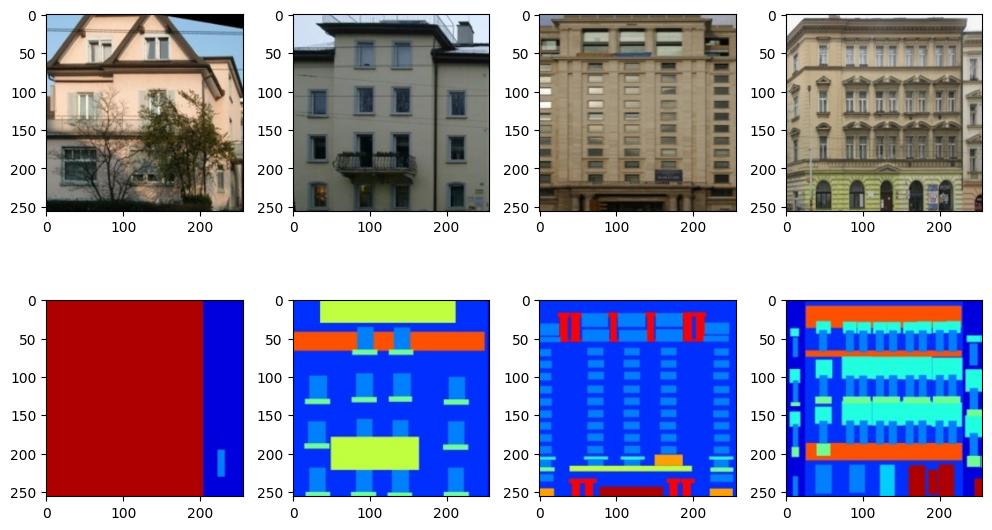

In [4]:
def visualise_dataset(dataset, indexes):
    figure, ax = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 6))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))
        
        ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[1, i].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=1)
    plt.show()    

visualise_dataset(facades_train_dataset, np.random.choice(range(len(facades_train_dataset)), 4))

## Running the training cycle

In the original paper they trained the model for _200 epochs_. Initially, I run the model in the same setting.
Though, it seems that generator can learn slightly more and produce more plausible _fakes_. I will try to train the model for _400 epochs_ and see whether 200th epoch checkpoint is different from 400th epoch.

In [5]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 3 * 1e-4
epochs = 400

print('Starting training:', device, 'was selected for training')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

generator_loss = GeneratorLoss(alpha=100)
discriminator_loss = DiscriminatorLoss()

generator_history = []
discriminator_history = []

for epoch in range(epochs):

    generator_losses = []
    discriminator_losses = []

    for real, condition in tqdm(train_dataloader):        
        condition = condition.to(device)
        real = real.to(device)

        # Generator's loss.
        fake = generator(condition)
        fake_pred = discriminator(fake, condition)
        gl = generator_loss(fake, real, fake_pred)

        # Discriminator's loss.
        fake = generator(condition).detach()
        fake_pred = discriminator(fake, condition)
        real_pred = discriminator(real, condition)
        dl = discriminator_loss(fake_pred, real_pred)

        generator_optimizer.zero_grad()
        gl.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()
        dl.backward()
        discriminator_optimizer.step()

        generator_losses.append(gl.item())
        discriminator_losses.append(dl.item())

    epoch_g_loss = np.mean(generator_losses)
    epoch_d_loss = np.mean(discriminator_losses)
    
    generator_history.append(epoch_g_loss)
    discriminator_history.append(epoch_d_loss)

    print('Epoch:', epoch, 'generator loss:', epoch_g_loss, 'discriminator loss:', epoch_d_loss)

    weights_dir = os.path.join('out', 'weights', 'pix2pix')
    os.makedirs(weights_dir, exist_ok=True)

    torch.save(generator.state_dict(), os.path.join(weights_dir, f"generator-{epoch:03d}-{epoch_g_loss:.3f}.pt"))
    torch.save(discriminator.state_dict(), os.path.join(weights_dir, f"discriminator-{epoch:03d}-{epoch_d_loss:.3f}.pt"))

Starting training: cuda was selected for training


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.65it/s]


Epoch: 0 generator loss: 23.94700382709503 discriminator loss: 0.16356887585192453


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.56it/s]


Epoch: 1 generator loss: 24.927629475593566 discriminator loss: 0.0014987824067793554


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.90it/s]


Epoch: 2 generator loss: 26.03631437778473 discriminator loss: 0.000818176324974047


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.85it/s]


Epoch: 3 generator loss: 20.705649182796478 discriminator loss: 0.3884526294191164


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.54it/s]


Epoch: 4 generator loss: 23.407265944480898 discriminator loss: 0.13374603774864227


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:53<00:00,  7.49it/s]


Epoch: 5 generator loss: 23.201007046699523 discriminator loss: 0.13225170811812859


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.07it/s]


Epoch: 6 generator loss: 21.301349692344665 discriminator loss: 0.2800971172354184


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.49it/s]


Epoch: 7 generator loss: 23.297798931598663 discriminator loss: 0.11941064456652384


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.41it/s]


Epoch: 8 generator loss: 21.866810331344606 discriminator loss: 0.23915966520144138


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.07it/s]


Epoch: 9 generator loss: 22.670347368717195 discriminator loss: 0.16353427682435723


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.32it/s]


Epoch: 10 generator loss: 21.494264345169068 discriminator loss: 0.22312684076838196


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.39it/s]


Epoch: 11 generator loss: 21.70024871587753 discriminator loss: 0.20236372653685974


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.43it/s]


Epoch: 12 generator loss: 21.801566114425658 discriminator loss: 0.1821437311178306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.75it/s]


Epoch: 13 generator loss: 22.17918832063675 discriminator loss: 0.18298006746161263


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.43it/s]


Epoch: 14 generator loss: 21.59633321046829 discriminator loss: 0.24797792223631404


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.67it/s]


Epoch: 15 generator loss: 22.029230349063873 discriminator loss: 0.21042501957679632


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.01it/s]


Epoch: 16 generator loss: 21.864710595607757 discriminator loss: 0.19841249598481225


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch: 17 generator loss: 22.11311193227768 discriminator loss: 0.20093186064856128


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.80it/s]


Epoch: 18 generator loss: 22.015604734420776 discriminator loss: 0.17244613584771287


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.61it/s]


Epoch: 19 generator loss: 22.240477809906007 discriminator loss: 0.18000648361514324


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 20 generator loss: 22.33947913646698 discriminator loss: 0.17715155098063406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.09it/s]


Epoch: 21 generator loss: 22.44096804857254 discriminator loss: 0.15319877932735834


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.57it/s]


Epoch: 22 generator loss: 22.137022688388825 discriminator loss: 0.1727318988450861


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.64it/s]


Epoch: 23 generator loss: 21.794097974300385 discriminator loss: 0.22334118264145217


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.47it/s]


Epoch: 24 generator loss: 20.888916795253753 discriminator loss: 0.2446019861480454


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.79it/s]


Epoch: 25 generator loss: 21.123424458503724 discriminator loss: 0.20543201530206714


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.48it/s]


Epoch: 26 generator loss: 21.170530259609222 discriminator loss: 0.18888417083915557


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.61it/s]


Epoch: 27 generator loss: 21.6195716714859 discriminator loss: 0.17485372569499305


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.41it/s]


Epoch: 28 generator loss: 21.4947469830513 discriminator loss: 0.1885432054789271


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.14it/s]


Epoch: 29 generator loss: 21.757512075901033 discriminator loss: 0.1827376567266765


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.97it/s]


Epoch: 30 generator loss: 21.488072564601897 discriminator loss: 0.19956743143731728


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.13it/s]


Epoch: 31 generator loss: 21.35726019859314 discriminator loss: 0.19732793287170353


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.11it/s]


Epoch: 32 generator loss: 21.740226261615753 discriminator loss: 0.1640062254377699


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 33 generator loss: 21.816228477954866 discriminator loss: 0.1737026355768103


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.55it/s]


Epoch: 34 generator loss: 23.606845369338988 discriminator loss: 0.12008866558229783


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.82it/s]


Epoch: 35 generator loss: 22.47119832992554 discriminator loss: 0.1637907591208932


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.41it/s]


Epoch: 36 generator loss: 21.98283191204071 discriminator loss: 0.2099695873557357


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.71it/s]


Epoch: 37 generator loss: 22.1213933300972 discriminator loss: 0.15898592793506394


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.87it/s]


Epoch: 38 generator loss: 22.664156382083892 discriminator loss: 0.17455245667690178


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.30it/s]


Epoch: 39 generator loss: 21.715694191455842 discriminator loss: 0.186536161613476


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.69it/s]


Epoch: 40 generator loss: 21.527139437198638 discriminator loss: 0.18656546748239633


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.36it/s]


Epoch: 41 generator loss: 20.98572277545929 discriminator loss: 0.18208716295615887


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch: 42 generator loss: 21.350759351253508 discriminator loss: 0.18400380396815308


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.68it/s]


Epoch: 43 generator loss: 21.267141835689543 discriminator loss: 0.17630974912492092


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.14it/s]


Epoch: 44 generator loss: 20.906512513160706 discriminator loss: 0.19453423215803922


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.48it/s]


Epoch: 45 generator loss: 21.687831306457518 discriminator loss: 0.14190039252731368


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.23it/s]


Epoch: 46 generator loss: 20.671673860549927 discriminator loss: 0.2789348611352034


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.35it/s]


Epoch: 47 generator loss: 20.009065811634063 discriminator loss: 0.2227020399874891


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.87it/s]


Epoch: 48 generator loss: 20.107445774078368 discriminator loss: 0.1981036994699389


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.68it/s]


Epoch: 49 generator loss: 20.29704466342926 discriminator loss: 0.2036823588158586


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.94it/s]


Epoch: 50 generator loss: 19.74058809518814 discriminator loss: 0.2472762149238406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 51 generator loss: 20.125061514377595 discriminator loss: 0.2035649554115662


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.64it/s]


Epoch: 52 generator loss: 19.78706540107727 discriminator loss: 0.19611304168502103


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.58it/s]


Epoch: 53 generator loss: 20.40985323667526 discriminator loss: 0.19846471136610488


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.10it/s]


Epoch: 54 generator loss: 19.890686135292054 discriminator loss: 0.2107911332740332


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.01it/s]


Epoch: 55 generator loss: 19.626064133644103 discriminator loss: 0.23266991942655296


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.27it/s]


Epoch: 56 generator loss: 19.454388930797577 discriminator loss: 0.24520738722712848


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.50it/s]


Epoch: 57 generator loss: 19.622308404445647 discriminator loss: 0.21335752015962497


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:00<00:00,  6.64it/s]


Epoch: 58 generator loss: 19.68778563499451 discriminator loss: 0.19856684902289998


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.21it/s]


Epoch: 59 generator loss: 19.760996999740602 discriminator loss: 0.216377297132276


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.25it/s]


Epoch: 60 generator loss: 19.942407281398772 discriminator loss: 0.2139876127122261


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.01it/s]


Epoch: 61 generator loss: 19.731403052806854 discriminator loss: 0.21351431260496612


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.57it/s]


Epoch: 62 generator loss: 19.56793084144592 discriminator loss: 0.20443124288271064


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.08it/s]


Epoch: 63 generator loss: 19.499893786907197 discriminator loss: 0.18967103836315802


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.82it/s]


Epoch: 64 generator loss: 19.80027770280838 discriminator loss: 0.20110056880599586


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.12it/s]


Epoch: 65 generator loss: 19.501718320846557 discriminator loss: 0.2157028096679278


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.26it/s]


Epoch: 66 generator loss: 19.436871225833894 discriminator loss: 0.19879381607403046


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.89it/s]


Epoch: 67 generator loss: 19.70210493326187 discriminator loss: 0.18658422810760386


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.81it/s]


Epoch: 68 generator loss: 19.24175529241562 discriminator loss: 0.22553929196845274


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.17it/s]


Epoch: 69 generator loss: 19.173195683956145 discriminator loss: 0.21293501843785634


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.67it/s]


Epoch: 70 generator loss: 19.277528860569 discriminator loss: 0.19286741838528543


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.09it/s]


Epoch: 71 generator loss: 18.675076513290406 discriminator loss: 0.24489425618667154


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch: 72 generator loss: 19.14367267847061 discriminator loss: 0.1945582325363648


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.26it/s]


Epoch: 73 generator loss: 19.135931129455567 discriminator loss: 0.23142572381111676


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.80it/s]


Epoch: 74 generator loss: 18.80773631334305 discriminator loss: 0.1909972559567541


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.78it/s]


Epoch: 75 generator loss: 19.07539330482483 discriminator loss: 0.20901778235143864


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.27it/s]


Epoch: 76 generator loss: 18.629930016994475 discriminator loss: 0.22330015985993668


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.86it/s]


Epoch: 77 generator loss: 18.775200476646422 discriminator loss: 0.22492562636936783


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.04it/s]


Epoch: 78 generator loss: 18.671951270103456 discriminator loss: 0.21899557823955548


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.29it/s]


Epoch: 79 generator loss: 18.59274925470352 discriminator loss: 0.20759998192836066


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.10it/s]


Epoch: 80 generator loss: 18.75831818819046 discriminator loss: 0.23723152199469041


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 81 generator loss: 18.23454349756241 discriminator loss: 0.24091341250168624


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.99it/s]


Epoch: 82 generator loss: 18.244315152168273 discriminator loss: 0.23686511852254624


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch: 83 generator loss: 18.3125692653656 discriminator loss: 0.2036339908154332


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.25it/s]


Epoch: 84 generator loss: 18.4737775015831 discriminator loss: 0.25369381664175306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.05it/s]


Epoch: 85 generator loss: 18.071356704235075 discriminator loss: 0.21869979703355058


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.96it/s]


Epoch: 86 generator loss: 18.292269411087037 discriminator loss: 0.23616464333608747


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.41it/s]


Epoch: 87 generator loss: 17.87015720129013 discriminator loss: 0.23637081214459613


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.98it/s]


Epoch: 88 generator loss: 18.105469748973846 discriminator loss: 0.22660874853521817


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.53it/s]


Epoch: 89 generator loss: 17.914703648090363 discriminator loss: 0.2504151300329249


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.62it/s]


Epoch: 90 generator loss: 17.79826653957367 discriminator loss: 0.24382972990104462


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.33it/s]


Epoch: 91 generator loss: 17.63846604347229 discriminator loss: 0.22091804705560208


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.29it/s]


Epoch: 92 generator loss: 17.60008406639099 discriminator loss: 0.21877277430845424


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.60it/s]


Epoch: 93 generator loss: 17.933741509914398 discriminator loss: 0.2314492877025623


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.05it/s]


Epoch: 94 generator loss: 17.507236852645875 discriminator loss: 0.23869395535730292


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.48it/s]


Epoch: 95 generator loss: 17.599797372817992 discriminator loss: 0.25387441001832484


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.07it/s]


Epoch: 96 generator loss: 17.578898651599886 discriminator loss: 0.23864019487635232


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.61it/s]


Epoch: 97 generator loss: 17.4268830537796 discriminator loss: 0.22125952914211666


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.06it/s]


Epoch: 98 generator loss: 17.53759422302246 discriminator loss: 0.23213302451127674


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.25it/s]


Epoch: 99 generator loss: 17.697393021583558 discriminator loss: 0.212861313726753


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.38it/s]


Epoch: 100 generator loss: 17.60792887210846 discriminator loss: 0.2299030966567807


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.24it/s]


Epoch: 101 generator loss: 17.132680599689483 discriminator loss: 0.2643943030142691


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.63it/s]


Epoch: 102 generator loss: 17.571680195331574 discriminator loss: 0.21857799424920812


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.79it/s]


Epoch: 103 generator loss: 17.39783955335617 discriminator loss: 0.2140656722721178


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.80it/s]


Epoch: 104 generator loss: 17.452232661247255 discriminator loss: 0.215534567956347


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.34it/s]


Epoch: 105 generator loss: 17.003670885562897 discriminator loss: 0.27300745388347425


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.02it/s]


Epoch: 106 generator loss: 17.280102486610414 discriminator loss: 0.20764397695107617


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.24it/s]


Epoch: 107 generator loss: 17.258732302188875 discriminator loss: 0.22501645308861043


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.47it/s]


Epoch: 108 generator loss: 17.32547571182251 discriminator loss: 0.2336192936229054


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.51it/s]


Epoch: 109 generator loss: 17.38104063510895 discriminator loss: 0.20175419963226887


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.51it/s]


Epoch: 110 generator loss: 17.27649142026901 discriminator loss: 0.20685147803742437


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.54it/s]


Epoch: 111 generator loss: 17.411632363796233 discriminator loss: 0.20633192409586626


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.87it/s]


Epoch: 112 generator loss: 17.109681527614594 discriminator loss: 0.2601035100396257


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.45it/s]


Epoch: 113 generator loss: 16.962085268497468 discriminator loss: 0.22604994194116443


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.99it/s]


Epoch: 114 generator loss: 17.20867046356201 discriminator loss: 0.20080230025574564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 115 generator loss: 17.000482017993928 discriminator loss: 0.24126453798176953


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.10it/s]


Epoch: 116 generator loss: 17.03490933895111 discriminator loss: 0.2320021976355929


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.95it/s]


Epoch: 117 generator loss: 16.805557203292846 discriminator loss: 0.24251282939338126


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.59it/s]


Epoch: 118 generator loss: 16.796434988975523 discriminator loss: 0.24647388152894564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.06it/s]


Epoch: 119 generator loss: 16.69710905313492 discriminator loss: 0.2269220736681018


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.95it/s]


Epoch: 120 generator loss: 16.73327273607254 discriminator loss: 0.2515825558049255


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.68it/s]


Epoch: 121 generator loss: 16.457647581100463 discriminator loss: 0.24028757913270965


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.35it/s]


Epoch: 122 generator loss: 16.59939759016037 discriminator loss: 0.22789847900974564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.98it/s]


Epoch: 123 generator loss: 16.44834629535675 discriminator loss: 0.2762355514400406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.93it/s]


Epoch: 124 generator loss: 16.40026609182358 discriminator loss: 0.24107724959845656


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  9.03it/s]


Epoch: 125 generator loss: 16.233324241638183 discriminator loss: 0.256978520473931


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.79it/s]


Epoch: 126 generator loss: 16.408383784294127 discriminator loss: 0.23138164982781745


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.46it/s]


Epoch: 127 generator loss: 16.446442828178405 discriminator loss: 0.24585975865396903


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.61it/s]


Epoch: 128 generator loss: 16.395344092845917 discriminator loss: 0.23374498290999327


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.52it/s]


Epoch: 129 generator loss: 16.647516441345214 discriminator loss: 0.23426749428384938


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.03it/s]


Epoch: 130 generator loss: 16.422302458286286 discriminator loss: 0.22872661180444992


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.19it/s]


Epoch: 131 generator loss: 16.249254055023194 discriminator loss: 0.2473250892042415


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.98it/s]


Epoch: 132 generator loss: 16.455430760383607 discriminator loss: 0.250287577342242


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.43it/s]


Epoch: 133 generator loss: 16.463832371234894 discriminator loss: 0.18816406220779755


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.23it/s]


Epoch: 134 generator loss: 16.630120849609376 discriminator loss: 0.22741181745543146


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.93it/s]


Epoch: 135 generator loss: 16.21022986650467 discriminator loss: 0.26481156013673174


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch: 136 generator loss: 16.28712683200836 discriminator loss: 0.21570104369777254


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.53it/s]


Epoch: 137 generator loss: 16.16098219394684 discriminator loss: 0.22672331196488812


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.96it/s]


Epoch: 138 generator loss: 16.28076426744461 discriminator loss: 0.2555553556699306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 139 generator loss: 15.984399218559265 discriminator loss: 0.26732044545933603


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.33it/s]


Epoch: 140 generator loss: 16.17437800168991 discriminator loss: 0.24022018038318493


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.49it/s]


Epoch: 141 generator loss: 16.00146546125412 discriminator loss: 0.21785186840512324


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.92it/s]


Epoch: 142 generator loss: 16.19092060804367 discriminator loss: 0.23411153670051135


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.32it/s]


Epoch: 143 generator loss: 16.379685125350953 discriminator loss: 0.22642800564412027


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.98it/s]


Epoch: 144 generator loss: 16.1248917222023 discriminator loss: 0.20622233310306912


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 145 generator loss: 16.18531936645508 discriminator loss: 0.2547428466094425


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.06it/s]


Epoch: 146 generator loss: 16.036421251296996 discriminator loss: 0.24679383799433707


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.34it/s]


Epoch: 147 generator loss: 16.01529252767563 discriminator loss: 0.2394096842754516


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.53it/s]


Epoch: 148 generator loss: 15.85817716360092 discriminator loss: 0.2762107927075704


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.12it/s]


Epoch: 149 generator loss: 15.755172967910767 discriminator loss: 0.2310119635553565


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.39it/s]


Epoch: 150 generator loss: 15.786712658405303 discriminator loss: 0.2746358051057905


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.75it/s]


Epoch: 151 generator loss: 15.998303501605987 discriminator loss: 0.22354655264643952


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.02it/s]


Epoch: 152 generator loss: 15.811824893951416 discriminator loss: 0.24424903523526154


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 153 generator loss: 15.997802739143372 discriminator loss: 0.22810059520183132


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.79it/s]


Epoch: 154 generator loss: 15.470941851139068 discriminator loss: 0.2822884765145136


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.69it/s]


Epoch: 155 generator loss: 15.596660842895508 discriminator loss: 0.23859658330329694


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.10it/s]


Epoch: 156 generator loss: 15.770758719444276 discriminator loss: 0.22381954115320696


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch: 157 generator loss: 15.832010583877564 discriminator loss: 0.24493763439531904


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.08it/s]


Epoch: 158 generator loss: 15.517600717544555 discriminator loss: 0.27924594989512114


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 159 generator loss: 15.522244310379028 discriminator loss: 0.24942814471258315


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.59it/s]


Epoch: 160 generator loss: 15.549744551181794 discriminator loss: 0.2346227201737929


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.92it/s]


Epoch: 161 generator loss: 15.797846763134002 discriminator loss: 0.27298320463625714


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.22it/s]


Epoch: 162 generator loss: 15.543880035877228 discriminator loss: 0.23404333791404497


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.78it/s]


Epoch: 163 generator loss: 15.686919598579406 discriminator loss: 0.24094971225596964


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.69it/s]


Epoch: 164 generator loss: 15.595320057868957 discriminator loss: 0.2596798641298665


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.45it/s]


Epoch: 165 generator loss: 15.643427379131317 discriminator loss: 0.26130513518000953


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.05it/s]


Epoch: 166 generator loss: 15.431763379573821 discriminator loss: 0.21036243438080418


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.11it/s]


Epoch: 167 generator loss: 15.396702723503113 discriminator loss: 0.2583810818404891


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 168 generator loss: 15.330040431022644 discriminator loss: 0.26493186471867375


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.22it/s]


Epoch: 169 generator loss: 15.638129732608796 discriminator loss: 0.21724568246107082


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.69it/s]


Epoch: 170 generator loss: 15.244059963226318 discriminator loss: 0.24634278583718697


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.47it/s]


Epoch: 171 generator loss: 15.287314376831056 discriminator loss: 0.2601964390341891


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.43it/s]


Epoch: 172 generator loss: 15.445405514240266 discriminator loss: 0.24535082724527457


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.00it/s]


Epoch: 173 generator loss: 15.555848479270935 discriminator loss: 0.21340998640022008


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.61it/s]


Epoch: 174 generator loss: 15.431540985107421 discriminator loss: 0.2250151115457993


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.16it/s]


Epoch: 175 generator loss: 15.339659492969513 discriminator loss: 0.22577295250026508


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.89it/s]


Epoch: 176 generator loss: 15.06740479707718 discriminator loss: 0.3014853810623754


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.18it/s]


Epoch: 177 generator loss: 15.337814230918884 discriminator loss: 0.21761814849625807


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.07it/s]


Epoch: 178 generator loss: 15.158127942085265 discriminator loss: 0.28450626258621925


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.48it/s]


Epoch: 179 generator loss: 15.270792798995972 discriminator loss: 0.23112139288219624


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.90it/s]


Epoch: 180 generator loss: 15.20040585756302 discriminator loss: 0.2623436216963455


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.28it/s]


Epoch: 181 generator loss: 15.211476058959962 discriminator loss: 0.2188829689193517


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.24it/s]


Epoch: 182 generator loss: 15.424102385044097 discriminator loss: 0.22536898974096403


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.31it/s]


Epoch: 183 generator loss: 15.12357761144638 discriminator loss: 0.2569420053868089


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.54it/s]


Epoch: 184 generator loss: 15.221023209095002 discriminator loss: 0.22411965044157114


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.36it/s]


Epoch: 185 generator loss: 15.397137067317963 discriminator loss: 0.2768612515926361


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.74it/s]


Epoch: 186 generator loss: 15.331367542743683 discriminator loss: 0.196316734169377


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.69it/s]


Epoch: 187 generator loss: 15.278644247055054 discriminator loss: 0.2314694127254188


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


Epoch: 188 generator loss: 15.12593655347824 discriminator loss: 0.2754663311422337


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.74it/s]


Epoch: 189 generator loss: 15.28153004169464 discriminator loss: 0.22913015575759346


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.20it/s]


Epoch: 190 generator loss: 15.254916260242462 discriminator loss: 0.23294667212001513


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.14it/s]


Epoch: 191 generator loss: 15.091736345291137 discriminator loss: 0.2548346879146993


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.99it/s]


Epoch: 192 generator loss: 15.277129032611846 discriminator loss: 0.20342173280601855


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.92it/s]


Epoch: 193 generator loss: 15.18341059923172 discriminator loss: 0.2514713535970077


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.47it/s]


Epoch: 194 generator loss: 15.090025444030761 discriminator loss: 0.24572980377532075


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.59it/s]


Epoch: 195 generator loss: 15.126146035194397 discriminator loss: 0.23497818740899676


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.85it/s]


Epoch: 196 generator loss: 15.054052481651306 discriminator loss: 0.238142510575708


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.01it/s]


Epoch: 197 generator loss: 15.073356573581696 discriminator loss: 0.2558786426571896


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.28it/s]


Epoch: 198 generator loss: 14.834582867622375 discriminator loss: 0.24044481971999632


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.88it/s]


Epoch: 199 generator loss: 15.283126480579377 discriminator loss: 0.20480560954252724


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.14it/s]


Epoch: 200 generator loss: 14.892700288295746 discriminator loss: 0.29186751568922775


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  8.00it/s]


Epoch: 201 generator loss: 14.998232986927032 discriminator loss: 0.21856740913237446


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.28it/s]


Epoch: 202 generator loss: 14.74810607433319 discriminator loss: 0.2867476353776874


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.18it/s]


Epoch: 203 generator loss: 15.033625838756562 discriminator loss: 0.19603238855022936


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.27it/s]


Epoch: 204 generator loss: 15.057327852249145 discriminator loss: 0.24151580872712658


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.30it/s]


Epoch: 205 generator loss: 15.11467668056488 discriminator loss: 0.23334590825252235


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.38it/s]


Epoch: 206 generator loss: 14.981126928329468 discriminator loss: 0.2199947684397921


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.49it/s]


Epoch: 207 generator loss: 15.017407071590423 discriminator loss: 0.2325762776954798


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.43it/s]


Epoch: 208 generator loss: 14.839559950828551 discriminator loss: 0.2654842088295845


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.78it/s]


Epoch: 209 generator loss: 15.063814985752106 discriminator loss: 0.24074491902487352


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.41it/s]


Epoch: 210 generator loss: 14.941287138462066 discriminator loss: 0.2156348936574068


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.28it/s]


Epoch: 211 generator loss: 14.922367943525314 discriminator loss: 0.2517029604432173


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.34it/s]


Epoch: 212 generator loss: 15.109825944900512 discriminator loss: 0.2128626074572094


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.15it/s]


Epoch: 213 generator loss: 14.652531576156616 discriminator loss: 0.30297314761905


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.01it/s]


Epoch: 214 generator loss: 14.62044367313385 discriminator loss: 0.26425503818318247


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.00it/s]


Epoch: 215 generator loss: 14.874126667976379 discriminator loss: 0.2247715038358001


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.30it/s]


Epoch: 216 generator loss: 14.944491896629334 discriminator loss: 0.23149605207028798


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.99it/s]


Epoch: 217 generator loss: 14.787906301021575 discriminator loss: 0.2406830877973698


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.88it/s]


Epoch: 218 generator loss: 14.618039855957031 discriminator loss: 0.2466245392046403


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.59it/s]


Epoch: 219 generator loss: 14.922701060771942 discriminator loss: 0.22713752439594828


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch: 220 generator loss: 14.94730077981949 discriminator loss: 0.22513484255410732


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.44it/s]


Epoch: 221 generator loss: 14.78539056777954 discriminator loss: 0.24152990985661746


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.46it/s]


Epoch: 222 generator loss: 14.63649846792221 discriminator loss: 0.24883931121032218


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.31it/s]


Epoch: 223 generator loss: 14.789459707736968 discriminator loss: 0.2390975898090983


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.22it/s]


Epoch: 224 generator loss: 14.788108999729156 discriminator loss: 0.24750210751546547


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.78it/s]


Epoch: 225 generator loss: 14.550876009464265 discriminator loss: 0.24742108079371974


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.10it/s]


Epoch: 226 generator loss: 14.921337230205536 discriminator loss: 0.22366730930763878


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch: 227 generator loss: 14.893314280509948 discriminator loss: 0.2082807529019192


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.37it/s]


Epoch: 228 generator loss: 14.598900380134582 discriminator loss: 0.2704582977271639


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.63it/s]


Epoch: 229 generator loss: 14.619927182197571 discriminator loss: 0.25926587569061665


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.72it/s]


Epoch: 230 generator loss: 14.611977798938751 discriminator loss: 0.23017274876241572


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.77it/s]


Epoch: 231 generator loss: 14.87615270614624 discriminator loss: 0.216911362503306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.95it/s]


Epoch: 232 generator loss: 14.649537439346313 discriminator loss: 0.24715562937199137


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.14it/s]


Epoch: 233 generator loss: 14.722460639476775 discriminator loss: 0.2705118001217488


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:56<00:00,  7.08it/s]


Epoch: 234 generator loss: 14.435868057012557 discriminator loss: 0.2514815959567204


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.75it/s]


Epoch: 235 generator loss: 14.844204068183899 discriminator loss: 0.18194032571802382


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.99it/s]


Epoch: 236 generator loss: 14.486677927970886 discriminator loss: 0.2766409382445272


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.22it/s]


Epoch: 237 generator loss: 14.759728469848632 discriminator loss: 0.20722486007260157


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.84it/s]


Epoch: 238 generator loss: 14.486520292758941 discriminator loss: 0.24690172384027392


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.93it/s]


Epoch: 239 generator loss: 14.675844373703002 discriminator loss: 0.25700492577743717


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.32it/s]


Epoch: 240 generator loss: 14.637761223316193 discriminator loss: 0.21940503184916452


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.37it/s]


Epoch: 241 generator loss: 14.61112770318985 discriminator loss: 0.24271375705022366


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.96it/s]


Epoch: 242 generator loss: 14.636948156356812 discriminator loss: 0.23938381141517312


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.08it/s]


Epoch: 243 generator loss: 14.39630213022232 discriminator loss: 0.26094877063063904


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.24it/s]


Epoch: 244 generator loss: 14.496996490955352 discriminator loss: 0.24227149924496189


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.76it/s]


Epoch: 245 generator loss: 14.51060362815857 discriminator loss: 0.24317158732097596


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.69it/s]


Epoch: 246 generator loss: 14.812417874336242 discriminator loss: 0.2345137136429548


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.77it/s]


Epoch: 247 generator loss: 14.644751164913178 discriminator loss: 0.21821848196472274


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.72it/s]


Epoch: 248 generator loss: 14.529973299503327 discriminator loss: 0.23142575986217706


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.33it/s]


Epoch: 249 generator loss: 14.447698047161103 discriminator loss: 0.25003275628812843


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.25it/s]


Epoch: 250 generator loss: 14.469713728427887 discriminator loss: 0.2527931838296354


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.78it/s]


Epoch: 251 generator loss: 14.643331842422485 discriminator loss: 0.17905500284337905


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.34it/s]


Epoch: 252 generator loss: 14.533197469711304 discriminator loss: 0.26466180360876024


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.35it/s]


Epoch: 253 generator loss: 14.752381870746612 discriminator loss: 0.21295659927709493


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.03it/s]


Epoch: 254 generator loss: 14.340229704380036 discriminator loss: 0.2734859447798226


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.81it/s]


Epoch: 255 generator loss: 14.513863019943237 discriminator loss: 0.22558852303714957


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.60it/s]


Epoch: 256 generator loss: 14.406617789268493 discriminator loss: 0.24647504740860313


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.95it/s]


Epoch: 257 generator loss: 14.33889475107193 discriminator loss: 0.2653110147535335


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.06it/s]


Epoch: 258 generator loss: 14.25595277070999 discriminator loss: 0.23612977273762226


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.81it/s]


Epoch: 259 generator loss: 14.5779498565197 discriminator loss: 0.20127925889100878


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.75it/s]


Epoch: 260 generator loss: 14.508284132480622 discriminator loss: 0.2329490881424863


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.14it/s]


Epoch: 261 generator loss: 14.53906409740448 discriminator loss: 0.22525373202282936


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.92it/s]


Epoch: 262 generator loss: 14.585038068294525 discriminator loss: 0.21966807401156985


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.71it/s]


Epoch: 263 generator loss: 14.302360773086548 discriminator loss: 0.255891523755854


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.10it/s]


Epoch: 264 generator loss: 14.602231004238128 discriminator loss: 0.21780669036728795


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.35it/s]


Epoch: 265 generator loss: 14.538184049129486 discriminator loss: 0.2466333572822623


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.65it/s]


Epoch: 266 generator loss: 14.235816932916642 discriminator loss: 0.28286735871457497


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.58it/s]


Epoch: 267 generator loss: 14.347296179533005 discriminator loss: 0.22348561988212168


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:46<00:00,  8.63it/s]


Epoch: 268 generator loss: 14.356696906089782 discriminator loss: 0.2256587559147738


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.34it/s]


Epoch: 269 generator loss: 14.428313512802124 discriminator loss: 0.24866121196420862


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.10it/s]


Epoch: 270 generator loss: 14.299746445417405 discriminator loss: 0.22201695610769093


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.15it/s]


Epoch: 271 generator loss: 14.499895045757293 discriminator loss: 0.2192671168129891


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.99it/s]


Epoch: 272 generator loss: 14.322368167638778 discriminator loss: 0.2524247460137121


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.83it/s]


Epoch: 273 generator loss: 14.41098839044571 discriminator loss: 0.22430576596409083


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch: 274 generator loss: 14.371830887794495 discriminator loss: 0.2443325831578113


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.10it/s]


Epoch: 275 generator loss: 14.41188013792038 discriminator loss: 0.23482423675712197


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.68it/s]


Epoch: 276 generator loss: 14.325994043350219 discriminator loss: 0.24052807037485763


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.85it/s]


Epoch: 277 generator loss: 14.28326740026474 discriminator loss: 0.263004344155197


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.03it/s]


Epoch: 278 generator loss: 14.40064202785492 discriminator loss: 0.2296233507641591


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.86it/s]


Epoch: 279 generator loss: 14.507807619571686 discriminator loss: 0.23720406774198635


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.78it/s]


Epoch: 280 generator loss: 14.367474551200866 discriminator loss: 0.23448321599513292


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.23it/s]


Epoch: 281 generator loss: 14.456745057106017 discriminator loss: 0.22659540167194792


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 282 generator loss: 14.362986323833466 discriminator loss: 0.23279090268071742


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.79it/s]


Epoch: 283 generator loss: 14.316048095226288 discriminator loss: 0.21366604872164316


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.95it/s]


Epoch: 284 generator loss: 14.311714947223663 discriminator loss: 0.24647625378798693


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.33it/s]


Epoch: 285 generator loss: 14.061798794269562 discriminator loss: 0.2763432922132779


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.82it/s]


Epoch: 286 generator loss: 14.43730072259903 discriminator loss: 0.197521409438923


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.60it/s]


Epoch: 287 generator loss: 14.365095829963684 discriminator loss: 0.24297824221546763


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.64it/s]


Epoch: 288 generator loss: 14.241370244026184 discriminator loss: 0.23464961072895676


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.50it/s]


Epoch: 289 generator loss: 14.228745849132538 discriminator loss: 0.22956011334841606


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch: 290 generator loss: 14.256092084646225 discriminator loss: 0.2511048892652616


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.89it/s]


Epoch: 291 generator loss: 14.276800098419189 discriminator loss: 0.24454798943654169


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.53it/s]


Epoch: 292 generator loss: 14.163505358695984 discriminator loss: 0.23386540219304153


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.79it/s]


Epoch: 293 generator loss: 14.229302852153777 discriminator loss: 0.24024445836548694


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.22it/s]


Epoch: 294 generator loss: 14.339298799037934 discriminator loss: 0.1999472690100083


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.48it/s]


Epoch: 295 generator loss: 14.272758386135102 discriminator loss: 0.23252522719325497


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 296 generator loss: 14.109885427951813 discriminator loss: 0.25367371026426555


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.38it/s]


Epoch: 297 generator loss: 14.212751905918122 discriminator loss: 0.2628572501731105


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.03it/s]


Epoch: 298 generator loss: 14.169625313282014 discriminator loss: 0.2265320848673582


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.29it/s]


Epoch: 299 generator loss: 14.48214864730835 discriminator loss: 0.19026480204833207


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.51it/s]


Epoch: 300 generator loss: 14.184208581447601 discriminator loss: 0.2643123544717673


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.79it/s]


Epoch: 301 generator loss: 14.421774533987046 discriminator loss: 0.19220739876793233


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.29it/s]


Epoch: 302 generator loss: 14.215906921625137 discriminator loss: 0.27054242428857833


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.75it/s]


Epoch: 303 generator loss: 14.25585991859436 discriminator loss: 0.23545370023697615


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.24it/s]


Epoch: 304 generator loss: 14.36714605808258 discriminator loss: 0.18683533806353808


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.02it/s]


Epoch: 305 generator loss: 14.406675622463226 discriminator loss: 0.22375274513149634


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.81it/s]


Epoch: 306 generator loss: 14.253163397312164 discriminator loss: 0.22752991480869242


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.57it/s]


Epoch: 307 generator loss: 14.409303648471832 discriminator loss: 0.20913982980302534


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.64it/s]


Epoch: 308 generator loss: 14.094260895252228 discriminator loss: 0.23548283076030202


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.60it/s]


Epoch: 309 generator loss: 14.31886744737625 discriminator loss: 0.19660298865492223


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.99it/s]


Epoch: 310 generator loss: 14.139236929416656 discriminator loss: 0.24246826651738956


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.33it/s]


Epoch: 311 generator loss: 14.15259202837944 discriminator loss: 0.26467424010625107


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.83it/s]


Epoch: 312 generator loss: 14.227499947547912 discriminator loss: 0.2083176602446474


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.99it/s]


Epoch: 313 generator loss: 14.279667944908143 discriminator loss: 0.23464367940789088


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.15it/s]


Epoch: 314 generator loss: 14.279560444355011 discriminator loss: 0.20317452288465573


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.57it/s]


Epoch: 315 generator loss: 14.399561059474944 discriminator loss: 0.2055823755619349


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.44it/s]


Epoch: 316 generator loss: 14.40764393568039 discriminator loss: 0.22888419498689472


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.97it/s]


Epoch: 317 generator loss: 14.225734252929687 discriminator loss: 0.25478730438044295


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.66it/s]


Epoch: 318 generator loss: 14.111278898715973 discriminator loss: 0.22543039124342612


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.91it/s]


Epoch: 319 generator loss: 14.2230335354805 discriminator loss: 0.2141460892278701


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.75it/s]


Epoch: 320 generator loss: 14.156225440502167 discriminator loss: 0.23349203324178233


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.01it/s]


Epoch: 321 generator loss: 14.261210532188416 discriminator loss: 0.20210656635987106


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.53it/s]


Epoch: 322 generator loss: 14.354499011039733 discriminator loss: 0.2182246970088454


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.90it/s]


Epoch: 323 generator loss: 14.028265223503112 discriminator loss: 0.23497758411103858


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.59it/s]


Epoch: 324 generator loss: 14.177236580848694 discriminator loss: 0.23487694905954412


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.57it/s]


Epoch: 325 generator loss: 14.197898132801056 discriminator loss: 0.20297620075754821


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.84it/s]


Epoch: 326 generator loss: 14.280629506111145 discriminator loss: 0.20699478140159044


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.43it/s]


Epoch: 327 generator loss: 14.527408205270767 discriminator loss: 0.19105482146609576


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.23it/s]


Epoch: 328 generator loss: 14.342817749977112 discriminator loss: 0.21036916912766174


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.05it/s]


Epoch: 329 generator loss: 14.209562952518462 discriminator loss: 0.20182031292235478


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.66it/s]


Epoch: 330 generator loss: 14.352812376022339 discriminator loss: 0.1983259495079983


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.69it/s]


Epoch: 331 generator loss: 14.377038505077362 discriminator loss: 0.20040605526301078


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.60it/s]


Epoch: 332 generator loss: 14.343243849277496 discriminator loss: 0.21059677900979296


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.81it/s]


Epoch: 333 generator loss: 14.306518383026123 discriminator loss: 0.21867138744099066


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.74it/s]


Epoch: 334 generator loss: 14.326792857646943 discriminator loss: 0.2129842869262211


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.57it/s]


Epoch: 335 generator loss: 14.179532955884934 discriminator loss: 0.23686170871020296


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.96it/s]


Epoch: 336 generator loss: 14.33625149846077 discriminator loss: 0.19337146528298035


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.55it/s]


Epoch: 337 generator loss: 14.509007995128632 discriminator loss: 0.1814025378203951


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 338 generator loss: 14.336006150245666 discriminator loss: 0.2103139735548757


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.54it/s]


Epoch: 339 generator loss: 14.294535427093505 discriminator loss: 0.2314515869144816


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.95it/s]


Epoch: 340 generator loss: 14.253659731149673 discriminator loss: 0.21383166299259757


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.17it/s]


Epoch: 341 generator loss: 14.465907440185546 discriminator loss: 0.17357751989271492


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.27it/s]


Epoch: 342 generator loss: 14.275386264324188 discriminator loss: 0.23268245629034937


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.60it/s]


Epoch: 343 generator loss: 14.530189158916473 discriminator loss: 0.1740120671922341


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.16it/s]


Epoch: 344 generator loss: 14.304878149032593 discriminator loss: 0.21468704544589856


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.94it/s]


Epoch: 345 generator loss: 14.339582290649414 discriminator loss: 0.2048040758667048


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.11it/s]


Epoch: 346 generator loss: 14.471313192844391 discriminator loss: 0.20073916114051826


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.51it/s]


Epoch: 347 generator loss: 14.32369896888733 discriminator loss: 0.2264474347094074


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.83it/s]


Epoch: 348 generator loss: 14.128377593755722 discriminator loss: 0.2525446159136482


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.49it/s]


Epoch: 349 generator loss: 14.306804480552673 discriminator loss: 0.1711610106844455


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.93it/s]


Epoch: 350 generator loss: 14.116661759614944 discriminator loss: 0.23613535918761044


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.23it/s]


Epoch: 351 generator loss: 14.238279111385346 discriminator loss: 0.2112633881007787


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.26it/s]


Epoch: 352 generator loss: 14.379158418178559 discriminator loss: 0.18161938644887413


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.64it/s]


Epoch: 353 generator loss: 14.134732971191406 discriminator loss: 0.2528337651921902


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.15it/s]


Epoch: 354 generator loss: 14.285713567733765 discriminator loss: 0.20311660809558815


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.58it/s]


Epoch: 355 generator loss: 14.506715655326843 discriminator loss: 0.1944517997931689


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.15it/s]


Epoch: 356 generator loss: 14.247435369491576 discriminator loss: 0.20556872254004702


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.95it/s]


Epoch: 357 generator loss: 14.194028911590577 discriminator loss: 0.20803646802087314


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.37it/s]


Epoch: 358 generator loss: 14.2002121925354 discriminator loss: 0.1959008120733779


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.18it/s]


Epoch: 359 generator loss: 14.23744662284851 discriminator loss: 0.22787982261157594


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.14it/s]


Epoch: 360 generator loss: 14.035396962165832 discriminator loss: 0.2442905581917148


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.47it/s]


Epoch: 361 generator loss: 14.254362004995347 discriminator loss: 0.19621117090660845


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.56it/s]


Epoch: 362 generator loss: 14.393388659954072 discriminator loss: 0.1977282151748659


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.75it/s]


Epoch: 363 generator loss: 14.02805384516716 discriminator loss: 0.2451334288646467


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.49it/s]


Epoch: 364 generator loss: 14.032424697875976 discriminator loss: 0.21209522835910322


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.76it/s]


Epoch: 365 generator loss: 14.155448719263077 discriminator loss: 0.20793527168920264


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.47it/s]


Epoch: 366 generator loss: 14.201203632354737 discriminator loss: 0.21469777453225106


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.73it/s]


Epoch: 367 generator loss: 14.036019614934922 discriminator loss: 0.2463211277197115


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.06it/s]


Epoch: 368 generator loss: 14.10457234621048 discriminator loss: 0.20756788475555368


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.96it/s]


Epoch: 369 generator loss: 14.199315311908721 discriminator loss: 0.21949831533478573


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.62it/s]


Epoch: 370 generator loss: 14.087980477809905 discriminator loss: 0.20493403857166415


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.60it/s]


Epoch: 371 generator loss: 14.082325122356416 discriminator loss: 0.23358456320827828


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.01it/s]


Epoch: 372 generator loss: 14.081648524999618 discriminator loss: 0.23988097545923664


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.33it/s]


Epoch: 373 generator loss: 14.02043433189392 discriminator loss: 0.21218279969645665


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.00it/s]


Epoch: 374 generator loss: 14.054202302694321 discriminator loss: 0.21802178271347658


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.23it/s]


Epoch: 375 generator loss: 13.890583171844483 discriminator loss: 0.24935971672995946


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.65it/s]


Epoch: 376 generator loss: 13.966987547874451 discriminator loss: 0.22001703503192402


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.52it/s]


Epoch: 377 generator loss: 14.023696241378785 discriminator loss: 0.20650226973695682


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.80it/s]


Epoch: 378 generator loss: 14.104691257476807 discriminator loss: 0.18891688039060683


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.29it/s]


Epoch: 379 generator loss: 14.209845077991485 discriminator loss: 0.21683712044730782


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.10it/s]


Epoch: 380 generator loss: 14.20418229341507 discriminator loss: 0.20438084269990214


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.07it/s]


Epoch: 381 generator loss: 14.057834870815277 discriminator loss: 0.22006131247151642


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.49it/s]


Epoch: 382 generator loss: 14.029374293088914 discriminator loss: 0.21590393946738914


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.44it/s]


Epoch: 383 generator loss: 14.028572437763215 discriminator loss: 0.23814608193468303


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.39it/s]


Epoch: 384 generator loss: 14.270581899881362 discriminator loss: 0.2093068152409978


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.75it/s]


Epoch: 385 generator loss: 14.06209364414215 discriminator loss: 0.20208068323438055


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.26it/s]


Epoch: 386 generator loss: 14.003075312376023 discriminator loss: 0.2565964624006301


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.39it/s]


Epoch: 387 generator loss: 14.095097739696502 discriminator loss: 0.1661575594759779


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.58it/s]


Epoch: 388 generator loss: 13.995939091444015 discriminator loss: 0.24188207448692992


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.81it/s]


Epoch: 389 generator loss: 14.074576673507691 discriminator loss: 0.2215741331281606


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.87it/s]


Epoch: 390 generator loss: 13.98778037071228 discriminator loss: 0.2308190511132125


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.21it/s]


Epoch: 391 generator loss: 14.034498252868651 discriminator loss: 0.2225773964507971


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.12it/s]


Epoch: 392 generator loss: 14.152755924463271 discriminator loss: 0.17403877497883513


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.08it/s]


Epoch: 393 generator loss: 13.730066291093827 discriminator loss: 0.2812907498277491


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.97it/s]


Epoch: 394 generator loss: 14.138130095005035 discriminator loss: 0.1871980612934567


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.51it/s]


Epoch: 395 generator loss: 14.070985347032547 discriminator loss: 0.21615685462602413


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.00it/s]


Epoch: 396 generator loss: 14.096657664775849 discriminator loss: 0.19531014585460071


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.00it/s]


Epoch: 397 generator loss: 13.82296786546707 discriminator loss: 0.23598945171339436


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.86it/s]


Epoch: 398 generator loss: 13.89823765039444 discriminator loss: 0.2637086593429558


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.09it/s]


Epoch: 399 generator loss: 13.977030365467071 discriminator loss: 0.18873879295075313


## Visualising training history

- **Generator**: it seems that generator sucessfully reduces the distance between generated fake and real images. Moreover, seems that training the model for longer was a step in the right direction. Though without side-by-side comparison it would be hard to tell.
- **Discriminator**: training is really unstable and it is not clear from the first sight whether it learns something. However, the overall quality seems acceptable.

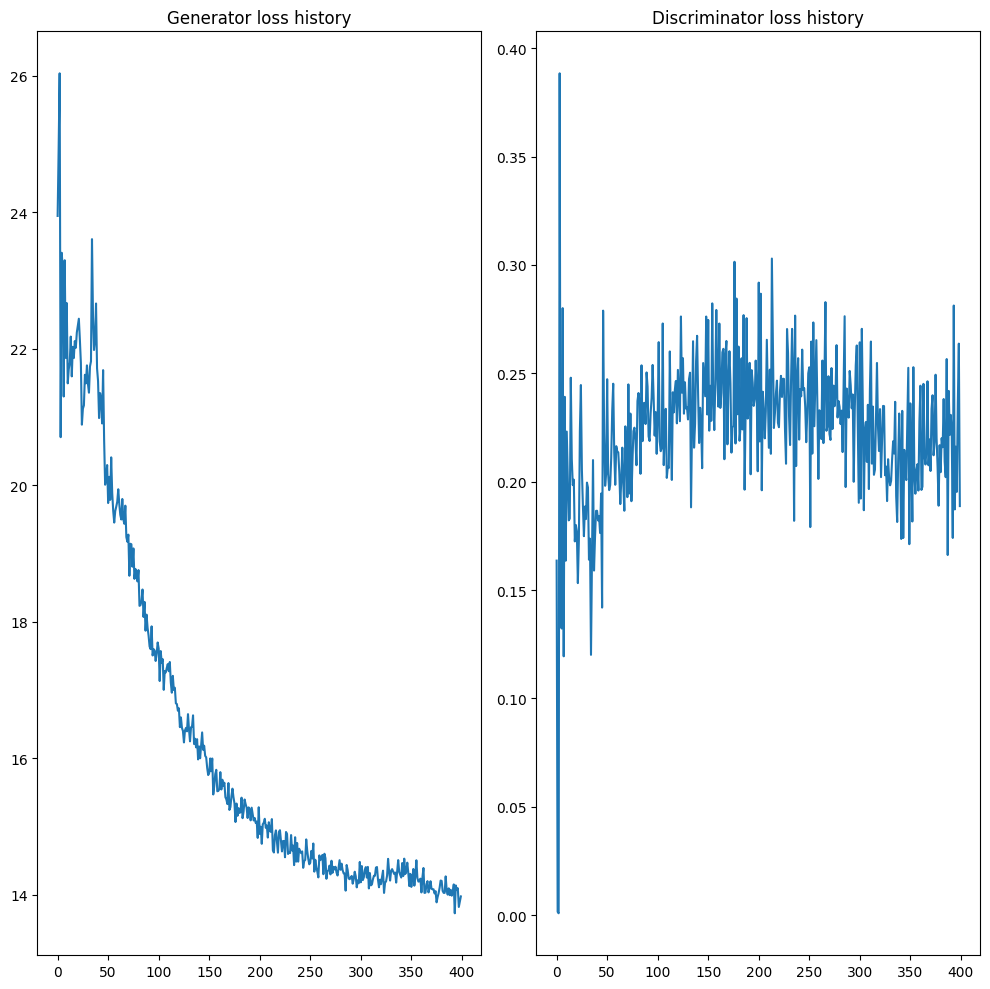

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Generator loss history")
ax[0].plot(generator_history)

ax[1].set_title("Discriminator loss history")
ax[1].plot(discriminator_history)

plt.tight_layout()
plt.show()

Let's visualise _200th epoch_ vs. _400th epoch_

- _200th epoch_: noticeable artifacts in the bottom of the image.
- _400th epoch_: less artficats in general and, especially, in the bottom of the image.

In [16]:
def visualise_inference(model_file, dataset, indexes):
    generator_model = Generator().to(device)
    generator_model.load_state_dict(torch.load(model_file))
    
    figure, axes = plt.subplots(nrows=len(indexes), ncols=3, figsize=(10, 10))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]

        input = torch.tensor(np.expand_dims(label, 0)).to(device)
        fake = generator_model(input)
        fake = fake.detach().cpu().numpy()

        fake = np.transpose(fake[0], (1,2,0))
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))

        axes[i, 0].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
        axes[i, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i, 2].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))

    column_names = ['Condition', 'Real', 'Fake']
    for i, ax in enumerate(axes.flatten()[:len(column_names)]):
        ax.axis('off')
        ax.set_title(column_names[i], fontweight='bold')

    figure.subplots_adjust(hspace=0.5, bottom=0.1)
    plt.tight_layout(pad=1)
    plt.show()    

In [8]:
validation_samples = np.random.choice(range(len(facades_val_dataset)), 6)
validation_samples

array([ 0, 68,  0, 75, 17, 26])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


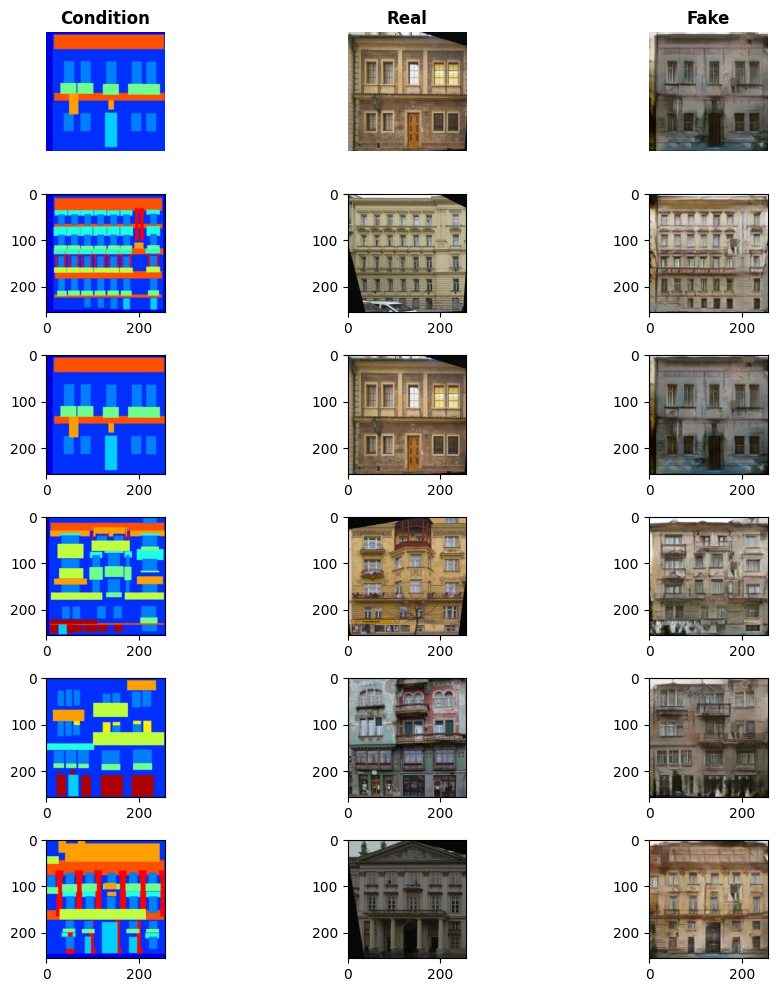

In [18]:
visualise_inference(os.path.join(weights_dir, 'generator-199-15.283.pt'), facades_val_dataset, validation_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


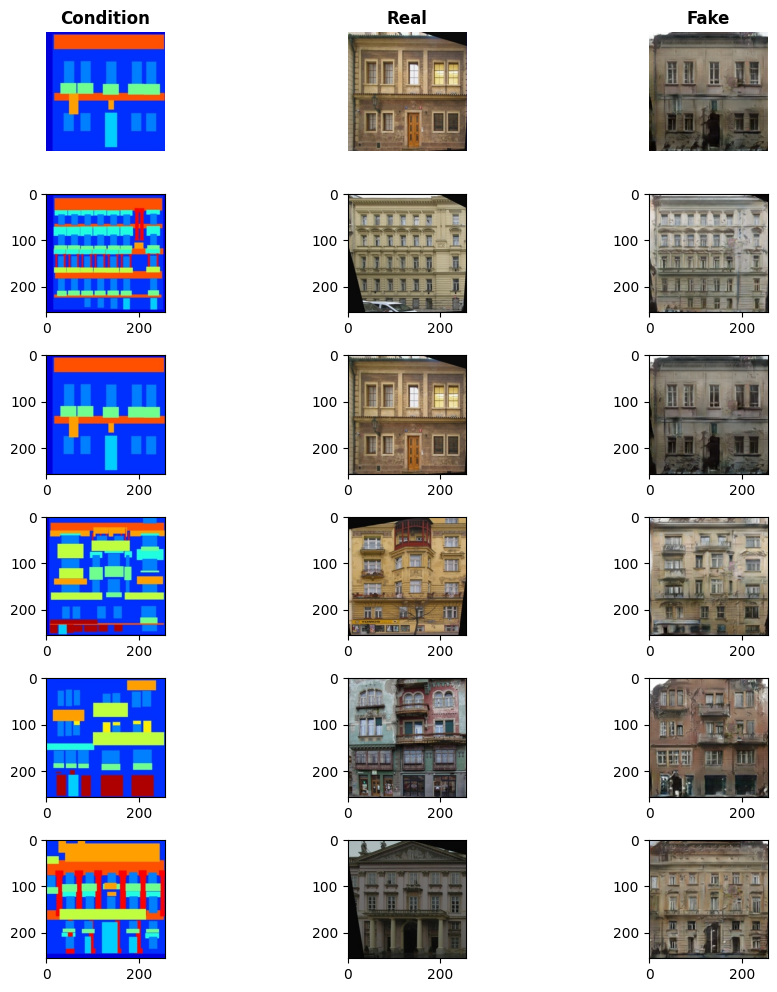

In [19]:
visualise_inference(os.path.join(weights_dir, 'generator-399-13.977.pt'), facades_val_dataset, validation_samples)

The results look extremelly plausible. It seems that the generator was able to learn the underlying distribution.
Both checkpoints look good or at least comparable to each other. I personally prefer the later (_epoch 400_) as it looks less messy.